In [1]:
!pip install category_encoders
!pip install xgboost

imports

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)
from scipy import interp

In [407]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Imputer,OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer,QuantileTransformer
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import make_pipeline,Pipeline,FeatureUnion
import category_encoders
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import roc_curve, auc

from itertools import cycle

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold,RandomizedSearchCV, cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA, TruncatedSVD

import glob

from xgboost import XGBClassifier

%matplotlib inline

In [722]:
source_dir = "dataset"
suffix_train = "/train/"
suffix_test =  "/test/"

filname_subs_features_train = "subs_features_train.csv"
filname_subs_bs_cons_train = "subs_bs_consumption_train.csv"
filname_subs_bs_data_session_train = "subs_bs_data_session_train.csv"
filname_subs_bs_voice_session_train = "subs_bs_voice_session_train.csv"


filname_subs_features_test= "subs_features_test.csv"
filname_subs_bs_cons_test = "subs_bs_consumption_test.csv"
filname_subs_bs_data_session_test = "subs_bs_data_session_test.csv"
filname_subs_bs_voice_session_test = "subs_bs_voice_session_test.csv"

filname_y_train = "subs_csi_train.csv"
filname_y_test = "subs_csi_test.csv"

target = "CSI"
seed = 33

Считаем train/test файлы.

In [723]:
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%y')



#features
df_sfeatures_train = pd.read_csv(source_dir + suffix_train + filname_subs_features_train, 
                             header=0, sep = ';', decimal=",")

df_sfeatures_test = pd.read_csv(source_dir + suffix_test + filname_subs_features_test, 
                             header=0, sep = ';', decimal=",")

#bs consumption
df_bsconsumption_train = pd.read_csv(source_dir + suffix_train + filname_subs_bs_cons_train, 
                             header=0, sep = ';', decimal=",")

df_bsconsumption_test = pd.read_csv(source_dir + suffix_test + filname_subs_bs_cons_test, 
                             header=0, sep = ';', decimal=",")

#data session
df_datasession_train = pd.read_csv(source_dir + suffix_train + filname_subs_bs_data_session_train, 
                             header=0, sep = ';', decimal=",")

df_datasession_test = pd.read_csv(source_dir + suffix_test + filname_subs_bs_data_session_test, 
                             header=0, sep = ';', decimal=",")


#voice session
df_voicesession_train = pd.read_csv(source_dir + suffix_train + filname_subs_bs_voice_session_train, 
                             header=0, sep = ';', decimal=",")

df_voicesession_test = pd.read_csv(source_dir + suffix_test + filname_subs_bs_voice_session_test, 
                             header=0, sep = ';', decimal=",")



# results
df_y_train = pd.read_csv(source_dir + suffix_train + filname_y_train, 
                             header=0, sep = ';', decimal=",")

df_y_test_pred = pd.read_csv(source_dir + suffix_test + filname_y_test, 
                             header=0, sep = ';', decimal=",")

In [724]:
# сливаем два массива в 1
df_datasession = pd.concat([df_datasession_train,df_datasession_test], axis=0, sort = False)

In [725]:
del df_datasession_train
del df_datasession_test

In [726]:
for_test = df_datasession[df_datasession['SK_ID'] == 1827]

In [727]:
for_test.head()

,SK_ID,CELL_LAC_ID,DATA_VOL_MB,START_TIME
177294,1827,72099,0.000050,11.03 07:00:00
177295,1827,255911,0.000060,05.03 20:00:00
177296,1827,255911,0.000680,05.03 19:00:00
177297,1827,205346,0.001403,05.03 19:00:00
177298,1827,181546,0.000007,15.03 19:00:00


In [728]:
for_test = for_test.groupby(['SK_ID','CELL_LAC_ID'],sort=False,as_index = False).agg({
    'DATA_VOL_MB' : ['sum']# total minutes by all cells
})

In [729]:
for_test.sort_values(by = 'CELL_LAC_ID',axis=0, ascending=True)

,SK_ID,CELL_LAC_ID,DATA_VOL_MB
,,,sum
39,1827,5688,3.874362e-08
26,1827,6011,3.081363e-04
35,1827,8034,6.552727e-06
54,1827,9776,5.216370e-07
82,1827,14347,2.454536e-05
81,1827,16681,3.402811e-07
123,1827,20651,2.900383e-04
28,1827,21597,3.761938e-04
124,1827,22237,7.066590e-06


In [730]:
for_test = df_bsconsumption_train[df_bsconsumption_train['SK_ID'] == 1827]

for_test = for_test.groupby('CELL_LAC_ID',sort=False,as_index = False).agg({
    'SK_ID' : 'first',
    'SUM_MINUTES' : ['sum'],# total minutes by all cells
    'SUM_DATA_MB' : ['sum'],#  total data by all cells
    'SUM_DATA_MIN' : ['sum']# total cells length
})

for_test.columns = for_test.columns.droplevel(1)

#False for ranks by high (1) to low (N)
for_test['rank'] = for_test['SUM_MINUTES'].rank(ascending=True,method = 'dense')
for_test['rank2'] = for_test['SUM_DATA_MB'].rank(ascending=True,method = 'dense')
for_test['rank3'] = for_test['SUM_DATA_MIN'].rank(ascending=True,method = 'dense')
for_test['result_rank'] = for_test['rank'].values + for_test['rank2'].values + for_test['rank3'].values
for_test.drop(['rank','rank2','rank3'],axis = 1, inplace = True)
for_test[for_test.result_rank > 300].sort_values('result_rank')

'''#df_bsconsumption_train['CELL_MAX_MINUTES_ID'] 
#cell with max minutes
max_ind = for_test.SUM_MINUTES.idxmax()
print (
for_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_MINUTES']]
)


#cell with max data
max_ind = for_test.SUM_DATA_MB.idxmax()
print (
for_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_DATA_MB']]
)

#cell with length session
max_ind = for_test.SUM_DATA_MIN.idxmax()
print (
for_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_DATA_MIN']]
)



#cell with min minutes
max_ind = for_test.SUM_MINUTES.idxmin()
print (
for_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_MINUTES']]
)


#cell with min data
max_ind = for_test.SUM_DATA_MB.idxmin()
print (
for_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_DATA_MB']]
)

#cell with length session
max_ind = for_test.SUM_DATA_MIN.idxmin()
print (
for_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_DATA_MIN']]
)'''

"#df_bsconsumption_train['CELL_MAX_MINUTES_ID'] \n#cell with max minutes\nmax_ind = for_test.SUM_MINUTES.idxmax()\nprint (\nfor_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_MINUTES']]\n)\n\n\n#cell with max data\nmax_ind = for_test.SUM_DATA_MB.idxmax()\nprint (\nfor_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_DATA_MB']]\n)\n\n#cell with length session\nmax_ind = for_test.SUM_DATA_MIN.idxmax()\nprint (\nfor_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_DATA_MIN']]\n)\n\n\n\n#cell with min minutes\nmax_ind = for_test.SUM_MINUTES.idxmin()\nprint (\nfor_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_MINUTES']]\n)\n\n\n#cell with min data\nmax_ind = for_test.SUM_DATA_MB.idxmin()\nprint (\nfor_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_DATA_MB']]\n)\n\n#cell with length session\nmax_ind = for_test.SUM_DATA_MIN.idxmin()\nprint (\nfor_test[for_test.index == max_ind][['CELL_LAC_ID','MON','SUM_DATA_MIN']]\n)"

In [731]:
# сливаем два массива в 1
df_bsconsumption = pd.concat([df_bsconsumption_train,df_bsconsumption_test], axis=0, sort = False)

In [732]:
del df_bsconsumption_train
del df_bsconsumption_test

In [733]:
# производим аггрегацию
df_bsconsumption = df_bsconsumption.groupby('SK_ID',sort=False,as_index = False).agg({
    #'CELL_LAC_ID' : 'count', # get count of cells by sk_id
    'SUM_MINUTES' : ['sum'],# total minutes by all cells
    'SUM_DATA_MB' : ['sum'],#  total data by all cells
    'SUM_DATA_MIN' : ['sum']# total cells length
    # max cell with minutes, data, data_min
    #'CELL_LAC_ID' : ['']
   
})
df_bsconsumption.columns = df_bsconsumption.columns.droplevel(1)

In [857]:
df_union_train = pd.merge(df_y_train, df_sfeatures_train,  on=['SK_ID'])

In [858]:
df_union_test = pd.merge(df_y_test_pred,df_sfeatures_test, on=['SK_ID'])

In [859]:
df = pd.concat([df_union_train,df_union_test], axis=0, sort = False)

In [860]:
del df_union_train

In [861]:
del df_union_test

In [862]:
df.shape

(106400, 38)

In [863]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106400 entries, 0 to 58988
Data columns (total 38 columns):
SK_ID               106400 non-null int64
CSI                 47411 non-null float64
CONTACT_DATE        106400 non-null object
SNAP_DATE           106400 non-null object
COM_CAT#1           106400 non-null int64
COM_CAT#2           106400 non-null int64
COM_CAT#3           106400 non-null int64
BASE_TYPE           106400 non-null int64
ACT                 106400 non-null int64
ARPU_GROUP          106358 non-null float64
COM_CAT#7           106400 non-null int64
COM_CAT#8           101541 non-null float64
DEVICE_TYPE_ID      106098 non-null float64
INTERNET_TYPE_ID    106098 non-null float64
REVENUE             106400 non-null float64
ITC                 106400 non-null float64
VAS                 106400 non-null float64
RENT_CHANNEL        106400 non-null float64
ROAM                106400 non-null float64
COST                106400 non-null float64
COM_CAT#17          106400 

In [864]:
# set option to view more columns as by default
pd.set_option('display.max_columns', df.shape[1])

In [865]:
df.columns = df.columns.str.replace("[#]", "_")

In [866]:
df.head()

,SK_ID,CSI,CONTACT_DATE,SNAP_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_24,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
0,2,0.0,04.05,01.03.02,7,77,10,1,1,10.0,2,1318.0,5.0,2.0,0.133708,0.007335,0.084167,0.055325,0.0,0.004982,0.0,0.0,0.026212,0.706893,0.019298,0.706893,0.133897,31.12,1,1,0.002070,0.007335,0.000050,0.002785,0.029765,0.027579,0.103896,NaN
1,2,0.0,04.05,01.02.02,7,77,9,1,1,10.0,2,1318.0,5.0,2.0,0.134224,0.001590,0.084167,0.055312,0.0,0.004396,0.0,0.0,0.026212,0.707528,0.019298,0.707528,0.134836,31.12,1,1,0.003913,0.001590,0.000018,0.001954,0.054871,0.027579,0.103896,NaN
2,2,0.0,04.05,01.05.02,7,77,12,1,1,9.0,2,1318.0,5.0,2.0,0.128917,0.008331,0.084167,0.055257,0.0,0.005078,0.0,0.0,0.026212,0.705129,0.019298,0.705129,0.129093,31.12,1,1,0.001801,0.008317,0.000081,0.002441,0.018126,0.027579,0.103896,9.0
3,2,0.0,04.05,01.01.02,7,77,17,1,1,6.0,2,1318.0,5.0,2.0,0.117077,0.002301,0.084167,0.055353,0.0,0.004471,0.0,0.0,0.087185,0.701424,0.086379,0.697846,0.118129,31.12,1,0,0.001798,0.002048,0.000033,0.002331,0.022108,0.027579,0.103896,NaN
4,2,0.0,04.05,01.04.02,7,77,11,1,1,8.0,2,1318.0,5.0,2.0,0.126715,0.002080,0.084167,0.055187,0.0,0.004436,0.0,0.0,0.026212,0.704850,0.019298,0.704850,0.126587,31.12,1,1,0.006520,0.001408,0.000010,0.001709,0.022772,0.027579,0.103896,9.0


In [867]:
df.tail()

,SK_ID,CSI,CONTACT_DATE,SNAP_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_24,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
58984,6156,NaN,14.04,01.03.02,4,54,5,2,1,4.0,3,1324.0,5.0,2.0,0.110392,0.000728,0.084167,0.054969,0.0,0.004281,0.0,0.0,0.026212,0.699214,0.019298,0.699214,0.111080,31.12,1,1,0.003236,0.000728,0.000000,0.000000,0.003116,0.027579,0.103896,10.0
58985,6156,NaN,14.04,01.08.01,4,54,5,2,1,1.0,3,1324.0,5.0,2.0,0.108153,0.000000,0.084167,0.054966,0.0,0.004206,0.0,0.0,0.026212,0.698482,0.019298,0.698482,0.109461,31.12,1,1,0.000569,0.000000,0.000000,0.000000,0.000862,0.027579,0.103896,9.0
58986,6156,NaN,14.04,01.05.01,4,54,5,2,1,2.0,3,1324.0,5.0,2.0,0.108803,0.002199,0.084418,0.055716,0.0,0.004506,0.0,0.0,0.026212,0.698480,0.019298,0.698480,0.109534,31.12,1,1,0.003103,0.002199,0.001328,0.005336,0.023826,0.027579,0.103896,2.0
58987,6156,NaN,14.04,01.04.02,4,54,5,2,1,1.0,3,1324.0,5.0,2.0,0.108261,0.000000,0.084167,0.054968,0.0,0.004207,0.0,0.0,0.026212,0.698520,0.019298,0.698520,0.109409,31.12,1,1,0.001198,0.000000,0.000000,0.000000,0.002594,0.027579,0.103896,10.0
58988,6156,NaN,14.04,01.10.01,4,54,5,2,1,4.0,3,1324.0,5.0,2.0,0.110345,0.000177,0.084167,0.054971,0.0,0.004225,0.0,0.0,0.026212,0.699241,0.019298,0.699241,0.109618,31.12,1,1,0.009500,0.000000,0.000000,0.000000,0.005362,0.027579,0.103896,9.0


In [868]:
df.describe()

,SK_ID,CSI,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
count,106400.000000,47411.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106358.000000,106400.000000,101541.000000,106098.000000,106098.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,102936.000000
mean,4876.034201,0.156694,4.503421,41.075367,5.271100,1.939070,0.990705,7.580370,2.400451,870.832580,4.610162,1.908113,0.128907,0.018490,0.087468,0.057185,0.000050,0.006531,0.003301,0.003521,0.026593,0.704000,0.019748,0.703853,0.126349,0.999878,0.988769,0.016675,0.017986,0.004444,0.004695,0.045831,0.028238,0.104961,5.582323
std,2812.580460,0.363515,2.182422,22.237932,2.783232,0.239204,0.095962,3.231712,1.625670,515.018465,0.898524,0.726753,0.020725,0.031818,0.012046,0.012992,0.003958,0.005383,0.020150,0.026469,0.010831,0.006346,0.004545,0.006369,0.018020,0.011053,0.105381,0.024760,0.030927,0.015495,0.021385,0.051868,0.009022,0.009838,3.557936
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2436.000000,0.000000,3.000000,25.000000,5.000000,2.000000,1.000000,5.000000,1.000000,391.000000,5.000000,1.000000,0.115454,0.001027,0.084167,0.054996,0.000000,0.004429,0.000000,0.000000,0.026212,0.700358,0.019298,0.700214,0.115037,1.000000,1.000000,0.002037,0.000960,0.000000,0.000000,0.010774,0.027579,0.103896,2.000000
50%,4889.000000,0.000000,4.000000,38.000000,5.000000,2.000000,1.000000,8.000000,2.000000,926.000000,5.000000,2.000000,0.124508,0.006953,0.084212,0.055156,0.000000,0.005209,0.000000,0.000000,0.026212,0.702849,0.019298,0.702705,0.122497,1.000000,1.000000,0.008221,0.006679,0.000070,0.000000,0.030382,0.027579,0.103896,4.000000
75%,7310.000000,0.000000,6.000000,60.000000,5.000000,2.000000,1.000000,10.000000,3.000000,1318.000000,5.000000,2.000000,0.136094,0.022675,0.086573,0.056061,0.000000,0.007087,0.000000,0.000000,0.026212,0.705948,0.019298,0.705816,0.131878,1.000000,1.000000,0.021532,0.022035,0.002882,0.000190,0.062889,0.027579,0.103896,9.000000
max,9748.000000,1.000000,8.000000,83.000000,17.000000,2.000000,1.000000,12.000000,9.000000,1702.000000,8.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000


Missing values

In [869]:
print (pd.concat([1- df.count() / df.shape[0], df.isna().sum()],axis=1))

                         0      1
SK_ID             0.000000      0
CSI               0.554408  58989
CONTACT_DATE      0.000000      0
SNAP_DATE         0.000000      0
COM_CAT_1         0.000000      0
COM_CAT_2         0.000000      0
COM_CAT_3         0.000000      0
BASE_TYPE         0.000000      0
ACT               0.000000      0
ARPU_GROUP        0.000395     42
COM_CAT_7         0.000000      0
COM_CAT_8         0.045667   4859
DEVICE_TYPE_ID    0.002838    302
INTERNET_TYPE_ID  0.002838    302
REVENUE           0.000000      0
ITC               0.000000      0
VAS               0.000000      0
RENT_CHANNEL      0.000000      0
ROAM              0.000000      0
COST              0.000000      0
COM_CAT_17        0.000000      0
COM_CAT_18        0.000000      0
COM_CAT_19        0.000000      0
COM_CAT_20        0.000000      0
COM_CAT_21        0.000000      0
COM_CAT_22        0.000000      0
COM_CAT_23        0.000000      0
COM_CAT_24        0.000000      0
COM_CAT_25    

Duplicates by SK_ID

Гипотеза - возможно стоит группировать и брать средние за 12 месяцев!

In [870]:
df[df.SK_ID == 3339].sort_values('SNAP_DATE',ascending=False) #3608

,SK_ID,CSI,CONTACT_DATE,SNAP_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_24,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
33580,3339,1.0,13.05,01.12.01,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.152471,0.087388,0.088690,0.058714,0.0,0.013697,0.0,0.0,0.026212,0.706760,0.019298,0.706760,0.136914,31.12,1,1,0.073945,0.086367,0.032632,0.017697,0.107121,0.027579,0.103896,2.0
33584,3339,1.0,13.05,01.11.01,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.162482,0.073122,0.095195,0.060743,0.0,0.012831,0.0,0.0,0.026212,0.710960,0.019298,0.710960,0.145504,31.12,1,1,0.080417,0.072672,0.058086,0.036068,0.134986,0.027579,0.103896,2.0
33581,3339,1.0,13.05,01.10.01,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.142156,0.033726,0.089917,0.059585,0.0,0.008382,0.0,0.0,0.026212,0.707238,0.019298,0.707238,0.135508,31.12,1,1,0.035139,0.033726,0.030531,0.053506,0.114678,0.027579,0.103896,2.0
33582,3339,1.0,13.05,01.09.01,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.145285,0.050051,0.084167,0.059378,0.0,0.009651,0.0,0.0,0.026212,0.707359,0.019298,0.707359,0.134488,31.12,1,1,0.053856,0.050051,0.033896,0.042431,0.106840,0.027579,0.103896,2.0
33577,3339,1.0,13.05,01.08.01,4,80,5,2,1,12.0,1,1489.0,5.0,2.0,0.153024,0.081527,0.104168,0.058596,0.0,0.014106,0.0,0.0,0.026212,0.706638,0.019298,0.706638,0.147071,31.12,1,1,0.031696,0.076724,0.040279,0.013300,0.083382,0.027579,0.103896,2.0
33586,3339,1.0,13.05,01.07.01,4,80,5,2,1,11.0,1,1489.0,5.0,2.0,0.138476,0.039324,0.084167,0.058606,0.0,0.008498,0.0,0.0,0.026212,0.705851,0.019298,0.705851,0.135376,31.12,1,1,0.020100,0.039313,0.040878,0.005856,0.097381,0.027579,0.103896,2.0
33579,3339,1.0,13.05,01.06.01,4,80,5,2,1,12.0,1,1489.0,5.0,2.0,0.143226,0.022492,0.084648,0.056036,0.0,0.006612,0.0,0.0,0.026212,0.708986,0.019298,0.708986,0.138648,31.12,1,1,0.026727,0.022298,0.011269,0.000004,0.163625,0.027579,0.103896,2.0
33587,3339,1.0,13.05,01.05.02,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.152648,0.071165,0.088724,0.058856,0.0,0.012058,0.0,0.0,0.026212,0.708091,0.019298,0.708091,0.138358,31.12,1,1,0.068973,0.071165,0.060654,0.010096,0.109189,0.027579,0.103896,2.0
33588,3339,1.0,13.05,01.04.02,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.146904,0.039467,0.090637,0.061338,0.0,0.009152,0.0,0.0,0.026212,0.708316,0.019298,0.708316,0.139378,31.12,1,1,0.037451,0.037747,0.065096,0.063092,0.092053,0.027579,0.103896,2.0
33585,3339,1.0,13.05,01.03.02,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.153125,0.089727,0.086884,0.062059,0.0,0.014080,0.0,0.0,0.026212,0.706693,0.019298,0.706693,0.138393,31.12,1,1,0.069798,0.086321,0.045110,0.081978,0.107824,0.027579,0.103896,2.0


#### Time features.

In [871]:
#for_test = pd.to_datetime(df.SNAP_DATE, format='%d/%m/%Y').dt.date

In [872]:
df.SNAP_DATE.unique()

array(['01.03.02', '01.02.02', '01.05.02', '01.01.02', '01.04.02',
       '01.12.01', '01.10.01', '01.09.01', '01.11.01', '01.08.01',
       '01.07.01', '01.06.01', '01.05.01'], dtype=object)

In [873]:
df.SNAP_DATE = pd.to_datetime(df.SNAP_DATE, format='%d.%m.%y')

In [874]:
df['Year_Snap_Date']=df.SNAP_DATE.dt.year #encode Year 2004 as 0 and 2005 as 1
df['Month_Snap_Date']=df.SNAP_DATE.dt.month
df['Year_Snap_Date'] = pd.Categorical(df['Year_Snap_Date'])
df['Year_Snap_Date'] = df['Year_Snap_Date'].cat.codes

In [875]:
df.drop(['SNAP_DATE'],axis = 1 , inplace = True)

Посмотрим на величину COM_CAT_24.

In [876]:
df.COM_CAT_24.unique()

array(['31.12', '06.05', '27.05', '30.05', '28.05', '29.05', '23.05',
       '24.05', '12.04', '15.04', '19.04', '23.04', '22.04', '08.04'],
      dtype=object)

In [877]:
df.COM_CAT_24.value_counts()
# стоит обратить внимание, на то значения когда не 31.12

31.12    106387
23.05         1
06.05         1
08.04         1
28.05         1
27.05         1
19.04         1
30.05         1
12.04         1
15.04         1
29.05         1
24.05         1
23.04         1
22.04         1
Name: COM_CAT_24, dtype: int64

Дропнем эту таблицу, т.к. она по сути состоит только из одного значения.

In [878]:
df.drop('COM_CAT_24', axis = 1, inplace = True)

Посмотрим теперь на Contact Date.

In [879]:
df.CONTACT_DATE = pd.to_datetime(df.CONTACT_DATE, format='%d.%m')

In [880]:
df['Month_CONTACT_DATE']=df.CONTACT_DATE.dt.month#encode Year 2004 as 0 and 2005 as 1
df['Day_CONTACT_DATE']=df.CONTACT_DATE.dt.day 

In [881]:
df.CONTACT_DATE.unique()

array(['1900-05-04T00:00:00.000000000', '1900-05-21T00:00:00.000000000',
       '1900-05-27T00:00:00.000000000', '1900-05-08T00:00:00.000000000',
       '1900-05-06T00:00:00.000000000', '1900-05-03T00:00:00.000000000',
       '1900-05-30T00:00:00.000000000', '1900-05-29T00:00:00.000000000',
       '1900-05-26T00:00:00.000000000', '1900-05-02T00:00:00.000000000',
       '1900-05-09T00:00:00.000000000', '1900-05-17T00:00:00.000000000',
       '1900-05-12T00:00:00.000000000', '1900-05-15T00:00:00.000000000',
       '1900-05-20T00:00:00.000000000', '1900-05-01T00:00:00.000000000',
       '1900-05-10T00:00:00.000000000', '1900-05-25T00:00:00.000000000',
       '1900-05-23T00:00:00.000000000', '1900-05-31T00:00:00.000000000',
       '1900-05-28T00:00:00.000000000', '1900-05-18T00:00:00.000000000',
       '1900-05-05T00:00:00.000000000', '1900-05-24T00:00:00.000000000',
       '1900-05-19T00:00:00.000000000', '1900-05-07T00:00:00.000000000',
       '1900-05-14T00:00:00.000000000', '1900-05-11

In [882]:
df.CONTACT_DATE.value_counts()

1900-05-12    2858
1900-04-24    2436
1900-04-07    2409
1900-04-09    2365
1900-05-08    2347
1900-04-13    2337
1900-04-05    2302
1900-04-23    2276
1900-05-13    2267
1900-04-11    2185
1900-04-04    2180
1900-04-14    2164
1900-04-20    2153
1900-04-06    2131
1900-04-25    2070
1900-04-17    2052
1900-04-26    2049
1900-04-27    1995
1900-05-17    1990
1900-05-09    1985
1900-04-21    1952
1900-04-12    1938
1900-05-02    1937
1900-04-19    1932
1900-05-11    1906
1900-04-16    1897
1900-04-15    1889
1900-05-04    1878
1900-04-18    1878
1900-05-05    1872
1900-05-10    1849
1900-05-14    1831
1900-04-03    1813
1900-04-22    1795
1900-04-01    1792
1900-04-10    1767
1900-05-22    1760
1900-05-03    1725
1900-05-01    1715
1900-05-30    1689
1900-05-28    1687
1900-05-07    1679
1900-05-21    1672
1900-05-06    1665
1900-04-02    1651
1900-05-16    1644
1900-05-27    1622
1900-05-24    1555
1900-05-29    1548
1900-04-08    1474
1900-05-25    1449
1900-05-26    1396
1900-05-19  

In [883]:
df.drop('CONTACT_DATE', axis = 1, inplace = True)

In [884]:
df_num_features = df.select_dtypes([np.number]).columns

In [885]:
df_cat_features = df.select_dtypes([np.object,'datetime']).columns

Numerical features analyse.

In [886]:
"""df_good = df[df_num_features][df.CSI == 0]
df_bad = df[df_num_features][df.CSI == 1]
df_good.describe() - df_bad.describe()"""

'df_good = df[df_num_features][df.CSI == 0]\ndf_bad = df[df_num_features][df.CSI == 1]\ndf_good.describe() - df_bad.describe()'

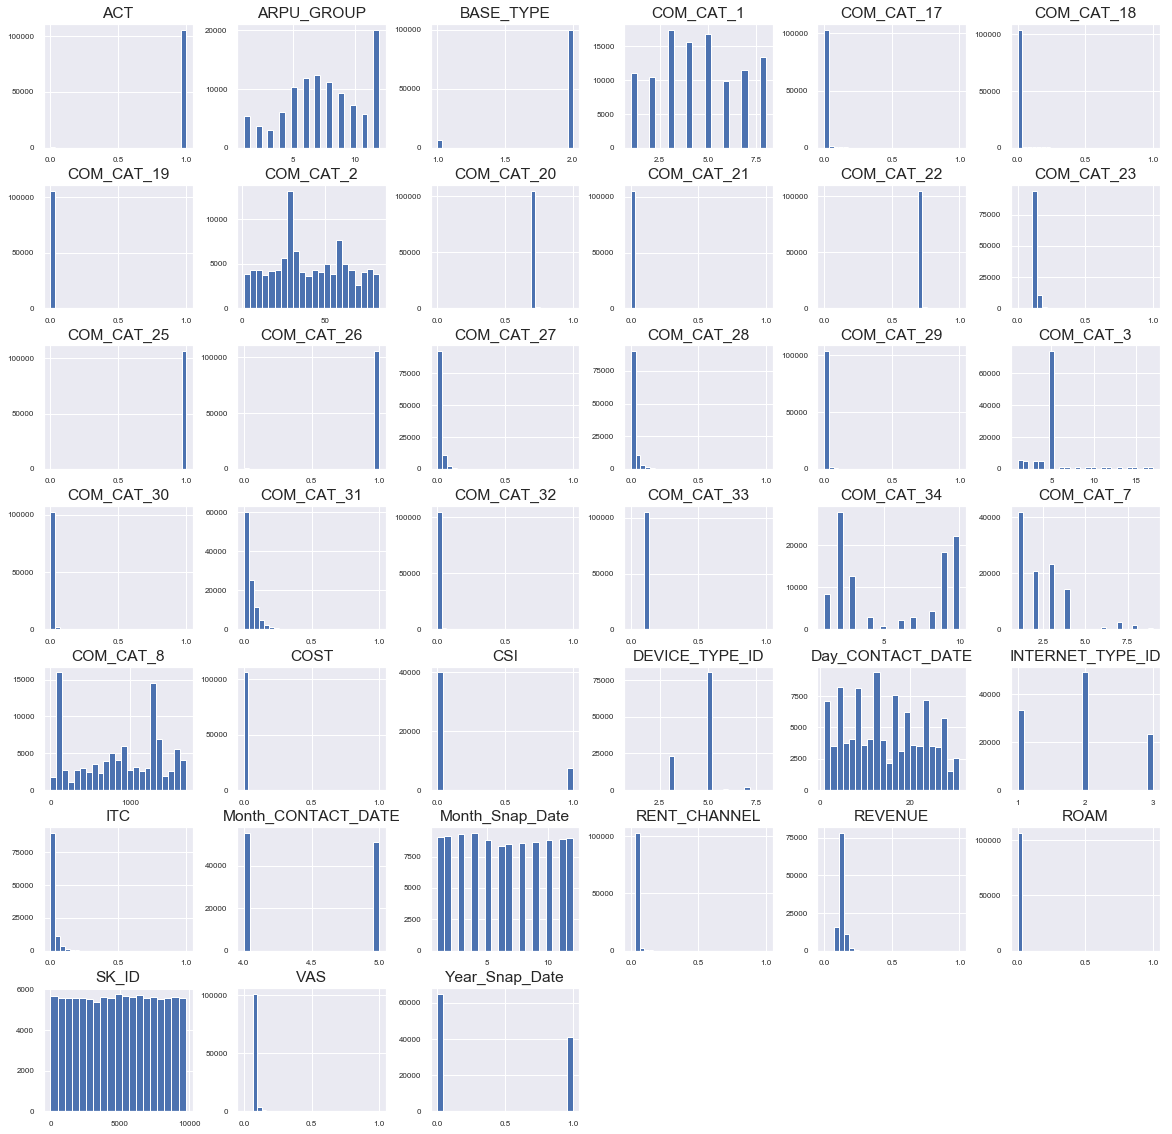

In [887]:
df[df_num_features].hist(figsize=(20, 20), bins='doane', xlabelsize=8, ylabelsize=8);

Countplots

In [888]:
for i, col in enumerate(df[df_num_features].columns.drop([target,'SK_ID'])):
    print(df[col].value_counts(normalize = True))

3    0.163976
5    0.158524
4    0.147650
8    0.126137
7    0.108327
1    0.103835
2    0.098064
6    0.093487
Name: COM_CAT_1, dtype: float64
30    0.103835
60    0.036513
32    0.027209
25    0.019737
43    0.018853
63    0.016795
77    0.014596
54    0.014549
28    0.014154
66    0.014135
40    0.014107
52    0.013976
15    0.013759
57    0.013647
68    0.013430
3     0.013299
65    0.012932
53    0.012679
24    0.012669
34    0.012641
4     0.011701
82    0.011476
59    0.011429
33    0.010883
20    0.010855
55    0.010855
58    0.010846
44    0.010836
14    0.010799
62    0.010658
        ...   
7     0.009868
18    0.009859
10    0.009840
23    0.009774
19    0.009709
78    0.009680
35    0.009521
11    0.009511
50    0.009483
2     0.009445
47    0.009398
5     0.009398
17    0.009342
31    0.009305
46    0.009267
22    0.009239
74    0.009192
49    0.009192
37    0.009098
64    0.009088
36    0.008957
76    0.008769
79    0.008562
73    0.007838
29    0.006184
81    0.004126
7

0.000000    0.130395
0.000012    0.000780
0.000087    0.000564
0.000078    0.000555
0.000090    0.000545
0.000003    0.000536
0.000128    0.000517
0.000064    0.000517
0.000032    0.000508
0.000110    0.000508
0.000009    0.000498
0.000044    0.000498
0.000035    0.000498
0.000046    0.000470
0.000081    0.000461
0.000102    0.000451
0.000052    0.000451
0.000131    0.000442
0.000058    0.000442
0.000049    0.000442
0.000206    0.000442
0.000038    0.000442
0.000165    0.000432
0.000075    0.000432
0.000183    0.000432
0.000070    0.000432
0.000119    0.000423
0.000215    0.000423
0.000061    0.000423
0.000096    0.000423
              ...   
0.072978    0.000009
0.018811    0.000009
0.041676    0.000009
0.017375    0.000009
0.021656    0.000009
0.026584    0.000009
0.015417    0.000009
0.026437    0.000009
0.004221    0.000009
0.038635    0.000009
0.080190    0.000009
0.018209    0.000009
0.044267    0.000009
0.037251    0.000009
0.103481    0.000009
0.019779    0.000009
0.031156    0



CHECK OUTLIERS FIRST!



Корреляции.

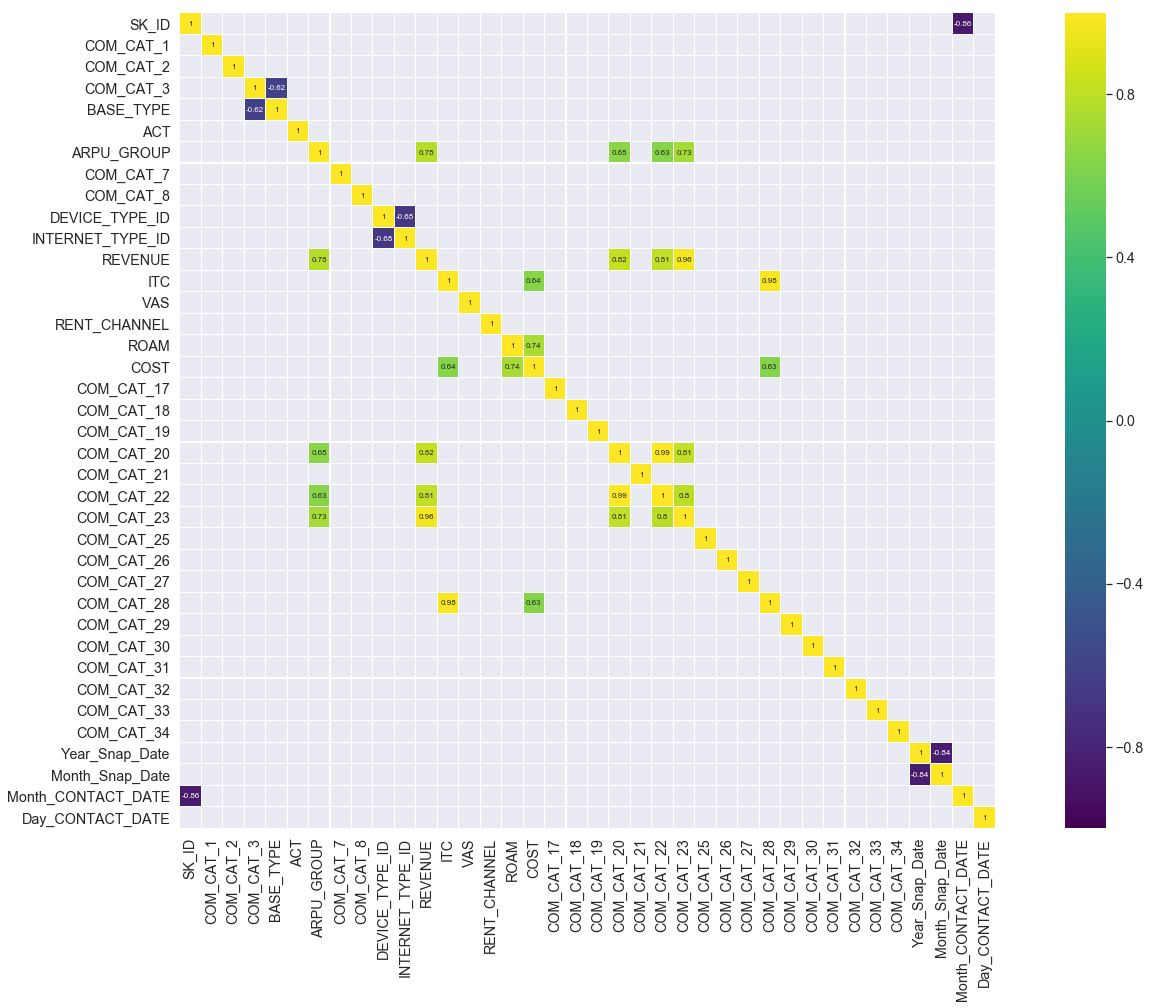

In [889]:
df_feature_corr = df.drop(target, axis = 1).corr(method = 'pearson')

plt.figure(figsize=(25, 15))
sns.heatmap(df_feature_corr[abs(df_feature_corr) > 0.6], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [890]:
#df.drop('COM_CAT_28',axis = 1, inplace = True)

In [891]:
#df.drop('COM_CAT_23',axis = 1, inplace = True)

In [892]:
#df.drop('COM_CAT_22',axis = 1, inplace = True)

In [893]:
#df.drop('COM_CAT_27',axis = 1, inplace = True) признак нужный

In [894]:
df.drop('Month_CONTACT_DATE',axis = 1, inplace = True)# дроп этой фичи улучшает скор

In [895]:
df.drop('COM_CAT_26',axis = 1, inplace = True)# дроп этой фичи улучшает скор

Выводы из корреляций:
1. Com_cat_3 и Base type коррелированы отрицательно.
2. ARPU Group сильнее всего связан с Revenue и Com Cat 23. ARPU = Total Revenue / # of Users.
3. Device type id and internet type id коррелированы отрицательно.
4. Revenue связан с ARPU Group и Com Cat 20, Com Cat 22 и Com Cat 23.
5. ITC с Com Cat 28.
6. ROAM с COST.
7. COST c Com Cat 28.
8. Com cat 20 c Com Cat 22 и Com Cat 23.

Обратить внимание на VAS - Value Added Services услуги, приносящие дополнительный доход.


Из анализа количества переменных в классах можно выделить:

Name: COM_CAT_25, dtype: int64

    1    47404
    0        7

Name: COM_CAT_26, dtype: int64

    1    46862
    0      549
    
    
Относительно 
- base type
- act
- com cat 17 and 18 19 - обратить внимание
- COM_CAT_20
- COM_CAT_25
- COM_CAT_26
- COM_CAT_29

In [896]:
df[df.COM_CAT_25 == 0]

,SK_ID,CSI,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_25,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34,Year_Snap_Date,Month_Snap_Date,Day_CONTACT_DATE
9253,905,0.0,4,59,1,2,1,1.0,3,1675.0,5.0,2.0,0.108027,0.000000,0.084167,0.054967,0.0,0.004206,0.000000,0.000000,0.026212,0.698438,0.019298,0.698438,0.109409,0,0.000247,0.000000,0.000000,0.000000,0.001175,0.027579,0.103896,10.0,1,5,2
9457,923,0.0,4,70,5,2,1,1.0,1,1327.0,5.0,2.0,0.108111,0.000000,0.084167,0.054965,0.0,0.004206,0.000000,0.000000,0.026212,0.698467,0.019298,0.698467,0.109409,0,0.000614,0.000000,0.000000,0.000000,0.005066,0.027579,0.103896,10.0,1,5,26
17274,1694,1.0,7,26,12,1,1,7.0,2,1062.0,5.0,2.0,0.121367,0.026369,0.084167,0.055048,0.0,0.006898,0.021531,0.000000,0.026212,0.701057,0.020778,0.700274,0.121836,0,0.004394,0.026369,0.000071,0.000004,0.016221,0.027605,0.110157,9.0,1,5,14
17644,1729,0.0,1,30,4,2,1,4.0,1,126.0,5.0,2.0,0.111819,0.035635,0.084167,0.055410,0.0,0.007870,0.000000,0.000000,0.026212,0.696938,0.019298,0.696938,0.109409,0,0.016563,0.035635,0.000272,0.002276,0.047276,0.027882,0.106706,9.0,1,5,1
18225,1785,1.0,4,36,5,2,1,1.0,7,82.0,5.0,1.0,0.107971,0.000000,0.084167,0.054968,0.0,0.004207,0.000000,0.000000,0.026212,0.698418,0.019298,0.698418,0.109409,0,0.000000,0.000000,0.000000,0.000000,0.005527,0.027579,0.103896,10.0,1,5,7
18342,1796,0.0,5,60,5,2,1,8.0,3,1249.0,3.0,3.0,0.125226,0.010987,0.086559,0.056261,0.0,0.005584,0.000000,0.000000,0.026212,0.703435,0.019298,0.703435,0.122149,0,0.013793,0.010987,0.000036,0.013846,0.015245,0.027579,0.103896,2.0,1,5,6
45837,4550,0.0,1,30,10,1,1,1.0,3,1627.0,5.0,2.0,0.107971,0.000000,0.084167,0.054965,0.0,0.004206,0.075694,0.000000,0.026212,0.698418,0.024502,0.695664,0.109409,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.027579,0.103896,NaN,1,5,25
7542,7071,NaN,1,30,2,2,1,4.0,2,NaN,5.0,1.0,0.110355,0.001375,0.084167,0.055050,0.0,0.004353,0.000000,0.000000,0.026212,0.699145,0.019298,0.699145,0.109461,0,0.010230,0.001375,0.000406,0.000000,0.007771,0.027579,0.103896,2.0,1,4,7
12110,8644,NaN,1,30,2,2,1,6.0,2,590.0,5.0,2.0,0.118663,0.017824,0.084167,0.055253,0.0,0.006044,0.000000,0.000000,0.026212,0.700765,0.019298,0.700765,0.115518,0,0.019653,0.017824,0.000994,0.000000,0.042777,0.027579,0.103896,7.0,1,4,25
17673,6666,NaN,1,30,3,2,1,3.0,1,144.0,5.0,2.0,0.109421,0.000000,0.084167,0.054983,0.0,0.004208,0.000000,0.000000,0.026212,0.698928,0.019298,0.698928,0.109409,0,0.006360,0.000000,0.000000,0.000000,0.005149,0.027579,0.103896,10.0,1,4,13


In [897]:
df.drop('COM_CAT_25',axis = 1, inplace = True)

In [898]:
#df_union[df_union.COM_CAT_26 == 0]

Что характерно, для всех значений COM_CAT_26=0 COM_CAT_34 в основном отсутсвует.

#### Target analysis.

In [899]:
df.CSI.value_counts()

0.0    39982
1.0     7429
Name: CSI, dtype: int64

Посмотрим на вид целевой переменной в зависимости от других признаков.

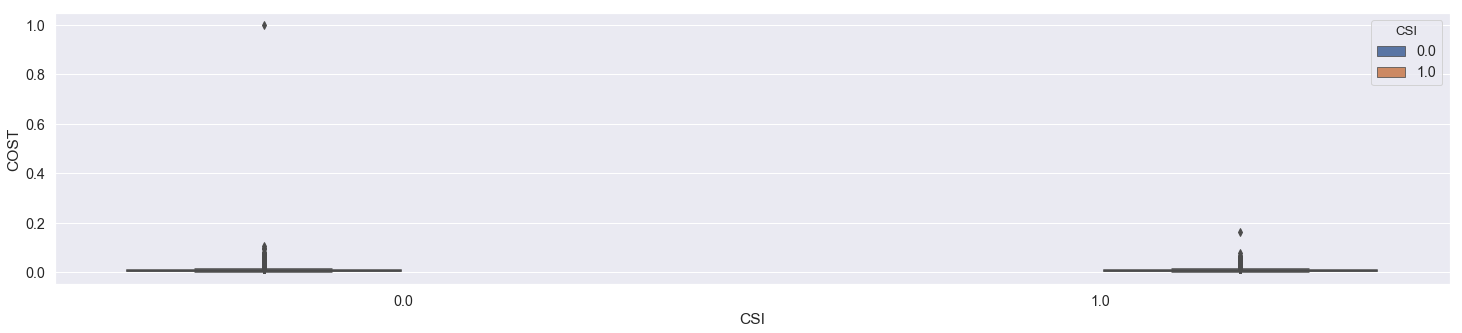

In [900]:
plt.figure(figsize=(25, 5))
sns.boxplot(x=df[target],y=df.COST, hue='CSI', data=df)
plt.show()

In [901]:
df[df.COST == 1]#скорее всего выброс

,SK_ID,CSI,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34,Year_Snap_Date,Month_Snap_Date,Day_CONTACT_DATE
13735,1344,0.0,1,30,3,2,1,12.0,1,126.0,5.0,2.0,0.314323,0.002431,0.084167,0.063686,1.0,1.0,0.0,0.0,0.026212,0.0,0.019298,0.0,0.315647,0.002878,0.002431,0.003612,0.045526,0.005358,0.058584,0.103896,2.0,0,8,29


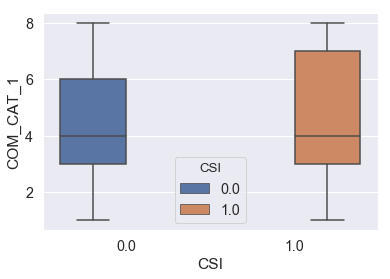

In [902]:
sns.boxplot(x=df[target],y=df.COM_CAT_1, hue='CSI', data=df)
#sns.catplot(x="day", y="total_bill", hue="smoker", kind="box", data=tips);

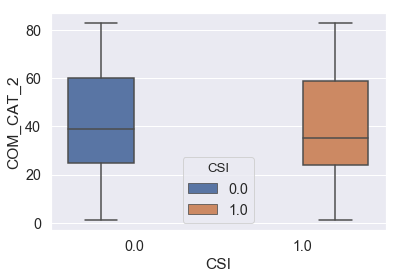

In [903]:
sns.boxplot(x=df[target],y=df.COM_CAT_2, hue='CSI', data=df)

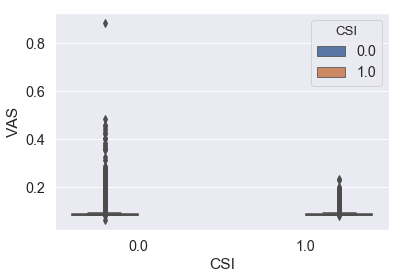

In [904]:
sns.boxplot(x=df[target],y=df.VAS, hue='CSI', data=df)
# check outlier

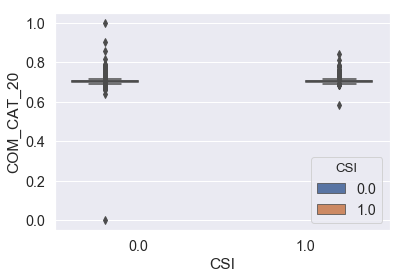

In [905]:
sns.boxplot(x=df[target],y=df.COM_CAT_20, hue='CSI', data=df) #check more 

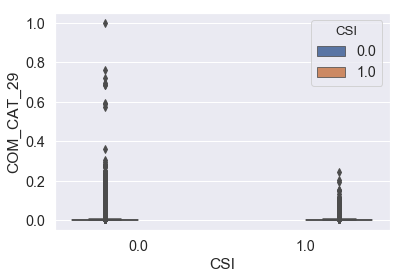

In [906]:
sns.boxplot(x=df[target],y=df.COM_CAT_29, hue='CSI', data=df) #check more 

In [907]:
df[df.COM_CAT_29 == 1]

,SK_ID,CSI,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34,Year_Snap_Date,Month_Snap_Date,Day_CONTACT_DATE
37081,3693,0.0,5,83,4,2,1,10.0,1,1520.0,5.0,2.0,0.133257,0.001914,0.085238,0.141942,0.0,0.011334,0.0,0.0,0.026212,0.701814,0.019298,0.701814,0.133496,0.004466,0.00183,1.0,0.0,0.010005,0.027579,0.103896,2.0,1,1,22


Проведем аггрегацию различных фич по SK_ID.

In [908]:
#df.describe()

In [909]:
#df_aggregate_test = df[(df.SK_ID == 2) | (df.SK_ID == 3339)]

In [910]:
# check what if in some variables customer can have more than value of characteristics
# check for ARPU_GROUP
#transfrom quantiles
#df.COM_CAT_26.value_counts()


In [911]:
#df_aggregate_test

In [912]:
#df.head()

Зададим функцию, которая собирает количество лет, за которые проводился сбор данных.

In [913]:
def get_len_unique(test_obj):
    return len(test_obj.unique())

In [914]:
df = df.groupby('SK_ID',sort=False,as_index = False).agg({
    'CSI' : ['mean'],
    'Year_Snap_Date': [get_len_unique],
    'Month_Snap_Date': 'count',
    #'Month_CONTACT_DATE' : 'first',
    'Day_CONTACT_DATE' : 'first',
    'COM_CAT_1': ['mean'],
    'COM_CAT_2': 'mean', 
    'COM_CAT_3' :'mean',
    'BASE_TYPE' : 'first',
    'ACT' : 'median',
    'ARPU_GROUP' : 'mean',
    'COM_CAT_7': 'first',
    'COM_CAT_8' : 'mean',
    'DEVICE_TYPE_ID' : 'first',
    'INTERNET_TYPE_ID' : 'first', 
    'REVENUE' : 'mean',
    'ITC' : 'mean',
    'VAS' : 'mean',
    'RENT_CHANNEL' : 'mean',
    'ROAM' : 'mean',
    'COST' : 'mean',
    'COM_CAT_17' : 'mean',
    'COM_CAT_18' : 'mean',
    'COM_CAT_19' : 'mean',
    'COM_CAT_20' : 'mean',
    'COM_CAT_21' : 'mean',
    'COM_CAT_22' : 'mean',
    'COM_CAT_23' : 'mean',
    #'COM_CAT_26' : 'mean',
    'COM_CAT_27' : 'mean',
    'COM_CAT_28' : 'mean',
    'COM_CAT_29' : 'mean',
    'COM_CAT_30' : 'mean',
    'COM_CAT_31' : 'mean',
    'COM_CAT_32' : 'mean',
    'COM_CAT_33' : 'mean',
    'COM_CAT_34' : 'mean'
})

In [915]:
df.columns = df.columns.droplevel(1)

In [916]:
df.tail()

,SK_ID,CSI,Year_Snap_Date,Month_Snap_Date,Day_CONTACT_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
9438,8518,NaN,2,12,3,1,30.0,5.000000,2,1.0,8.583333,1,184.000000,5.0,2.0,0.131094,0.023543,0.084629,0.055873,0.000474,0.007177,0.0,0.000000,0.026212,0.704271,0.019298,0.704271,0.129728,0.012079,0.023543,0.002219,0.003013,0.046954,0.027829,0.104284,7.250000
9439,5739,NaN,2,12,7,4,5.0,3.916667,2,1.0,10.083333,1,847.833333,5.0,1.0,0.135449,0.007057,0.086837,0.055661,0.000000,0.005155,0.0,0.030009,0.026212,0.707372,0.019542,0.707332,0.130054,0.027225,0.003949,0.009181,0.000000,0.085938,0.027591,0.104131,2.000000
9440,6474,NaN,2,12,4,5,48.0,5.000000,2,1.0,1.000000,4,NaN,3.0,3.0,0.108091,0.000000,0.084167,0.054978,0.000000,0.004207,0.0,0.000000,0.026212,0.698459,0.019298,0.698459,0.109529,0.000000,0.000000,0.000000,0.000000,0.008167,0.027579,0.103896,10.000000
9441,5430,NaN,2,12,11,1,30.0,5.000000,2,1.0,12.000000,1,795.000000,5.0,2.0,0.166261,0.050674,0.106172,0.057530,0.000000,0.011012,0.0,0.000000,0.026212,0.713701,0.019298,0.713701,0.156055,0.051584,0.050674,0.009619,0.005251,0.078006,0.027858,0.104399,2.000000
9442,6156,NaN,2,12,14,4,54.0,5.000000,2,1.0,1.750000,3,1324.000000,5.0,2.0,0.108708,0.000267,0.084188,0.055061,0.000000,0.004243,0.0,0.000000,0.026212,0.698650,0.019298,0.698650,0.109638,0.002217,0.000253,0.000121,0.000816,0.003885,0.027579,0.103896,7.666667


In [917]:
# посмотреть на csi больше 0 но меньше 1
df[(df.CSI < 1) & (df.CSI > 0)]

,SK_ID,CSI,Year_Snap_Date,Month_Snap_Date,Day_CONTACT_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34


In [918]:
print (pd.concat([1- df.count() / df.shape[0], df.isna().sum()],axis=1))

                         0     1
SK_ID             0.000000     0
CSI               0.552896  5221
Year_Snap_Date    0.000000     0
Month_Snap_Date   0.000000     0
Day_CONTACT_DATE  0.000000     0
COM_CAT_1         0.000000     0
COM_CAT_2         0.000000     0
COM_CAT_3         0.000000     0
BASE_TYPE         0.000000     0
ACT               0.000000     0
ARPU_GROUP        0.000000     0
COM_CAT_7         0.000000     0
COM_CAT_8         0.022133   209
DEVICE_TYPE_ID    0.000529     5
INTERNET_TYPE_ID  0.000529     5
REVENUE           0.000000     0
ITC               0.000000     0
VAS               0.000000     0
RENT_CHANNEL      0.000000     0
ROAM              0.000000     0
COST              0.000000     0
COM_CAT_17        0.000000     0
COM_CAT_18        0.000000     0
COM_CAT_19        0.000000     0
COM_CAT_20        0.000000     0
COM_CAT_21        0.000000     0
COM_CAT_22        0.000000     0
COM_CAT_23        0.000000     0
COM_CAT_27        0.000000     0
COM_CAT_28

In [919]:
# аттачим к аггрегированному датасету
df = pd.merge(df,df_bsconsumption, on=['SK_ID'],how = 'left')

In [920]:
df.head()

,SK_ID,CSI,Year_Snap_Date,Month_Snap_Date,Day_CONTACT_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,...,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34,SUM_MINUTES,SUM_DATA_MB,SUM_DATA_MIN
0,2,0.0,1,5,4,7,77.0,11.800000,1,1.0,8.600000,2,1318.000000,5.0,2.0,0.128128,0.004327,0.084167,0.055287,...,0.004673,0.000000,0.0,0.038407,0.705165,0.032714,0.704449,0.128508,0.003220,0.004140,0.000038,0.002244,0.029528,0.027579,0.103896,9.0,0.144137,0.012112,1.093219
1,3,0.0,2,9,21,4,51.0,13.000000,1,1.0,8.222222,2,751.444444,5.0,2.0,0.133601,0.015793,0.106932,0.055055,...,0.007315,0.068165,0.0,0.026212,0.705048,0.023984,0.702567,0.132894,0.008828,0.015793,0.000972,0.000070,0.011613,0.027579,0.103896,9.0,0.112944,0.009155,1.395130
2,4,0.0,2,12,27,8,12.0,3.833333,2,1.0,6.166667,3,1102.333333,3.0,3.0,0.118478,0.004834,0.085881,0.055038,...,0.004817,0.000000,0.0,0.026212,0.701650,0.019298,0.701650,0.116275,0.014066,0.003972,0.000000,0.000000,0.039371,0.027579,0.103896,3.0,0.246722,0.000000,0.000000
3,5,0.0,2,12,8,3,79.0,2.000000,2,1.0,8.833333,1,110.000000,5.0,2.0,0.129951,0.002000,0.085055,0.063784,...,0.005164,0.000000,0.0,0.026212,0.705427,0.019298,0.705427,0.130530,0.003737,0.002000,0.071332,0.001833,0.051395,0.027579,0.103896,2.0,0.402554,0.416140,2.278583
4,6,1.0,2,12,6,5,48.0,5.000000,2,1.0,2.166667,4,937.000000,3.0,3.0,0.108780,0.000103,0.084285,0.054984,...,0.004226,0.000000,0.0,0.026212,0.698688,0.019298,0.698688,0.109785,0.001804,0.000103,0.000000,0.000000,0.012235,0.027579,0.103900,3.0,0.073116,0.000000,0.000000


#### Baseline.

Train/test split.

In [921]:
split_index = 9443-5221

In [922]:
y = df[target]

In [923]:
X_train,X_test = df[:split_index].drop([target,'SK_ID'], axis = 1),df[split_index:].drop([target,'SK_ID'], axis = 1)

In [924]:
y_train = y[:split_index]

Pipeline.

In [925]:
df_num_features = list(df).copy()
df_num_features.remove(target)
df_num_features.remove('SK_ID')
#df_num_features

In [926]:
num_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean',copy = False)),
    ('scale', MinMaxScaler()),
    ('transform', QuantileTransformer(output_distribution='normal'))
])

In [927]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_features_pipeline, df_num_features),
        #('cat_ext', cat_ext_features_pipeline, cat_ext),
        #('cat_bin', cat_bin_features_pipeline, cat_bin)
    ]
)

In [928]:
clf_log = LogisticRegression(multi_class = 'ovr',
                             solver='liblinear',
                             random_state = seed,
                             n_jobs = -1,
                             max_iter = 10e2,
                             class_weight='balanced',
                             penalty = 'l2'
                            )

In [929]:
baseline_logit = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classify', clf_log)
    ]
)

In [427]:
def plot_curve(fpr, tpr):
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [428]:
def classify(estimator):
    y_pred_train = estimator.predict_proba(X_train)
    y_pred_test = estimator.predict_proba(X_test)
    print ("on train")
    print(classification_report(y_train, estimator.predict(X_train)))
    #print ("on test")
    #print(classification_report(y_test, y_pred_test)) 
    print ("AUC")
    fpr, tpr, _ = roc_curve(y_train, y_pred_train[:, 1])
    print (auc(fpr, tpr))
    plot_curve(fpr, tpr)
    return y_pred_test[:, 1]

In [429]:
logit_regr = baseline_logit.fit(X_train, y_train)

E:\Python\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


on train
              precision    recall  f1-score   support

         0.0       0.88      0.55      0.68      3566
         1.0       0.20      0.60      0.30       656

   micro avg       0.56      0.56      0.56      4222
   macro avg       0.54      0.58      0.49      4222
weighted avg       0.78      0.56      0.62      4222

AUC
0.595957074265078


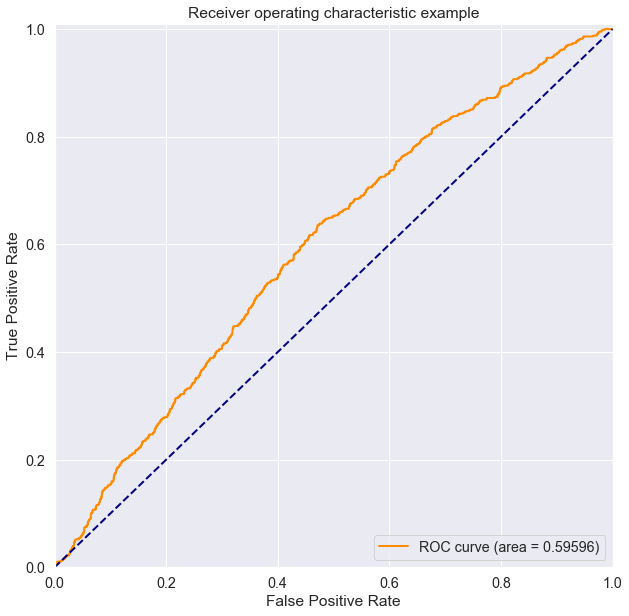

array([0.59833697, 0.56207288, 0.4104858 , ..., 0.53988544, 0.48118303,
       0.41271777])

In [430]:
classify(logit_regr)

#### Hyperparameters tune.

In [74]:
%%time

my_scorer = make_scorer(f1_score, average='weighted')
skv = KFold(n_splits = 10,random_state=seed, shuffle=False)

tuned_parameters = [
    {
    'classify__penalty': ['l2'],
    'classify__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 40, 50]
                    
                    },
    {
    'classify__penalty': ['l1'],
    'classify__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 40, 50]
                    }
    ]


bclf = GridSearchCV(baseline_logit, tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=9, n_jobs=-1,refit='roc_auc')

bclf.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished
D:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Wall time: 1min 44s


In [75]:
#for key in baseline_logit.get_params().keys():
#    print(key)

In [76]:
#bclf.cv_results_

In [77]:
def create_cv_plot(estimator):
    alphas = estimator.cv_results_['param_classify__C'].data
    scores = estimator.cv_results_['mean_train_score']
    combined = pd.DataFrame({'C':alphas, 'score':scores})
    plt.figure(figsize=(18, 10))

    plt.plot(combined.C[0:20], combined.score[0:20],'go-')
    plt.grid(True)
    plt.title('C and metrics plt')
    plt.xlabel('C values') 
    plt.ylabel('mean_train_score error')

D:\Programs\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


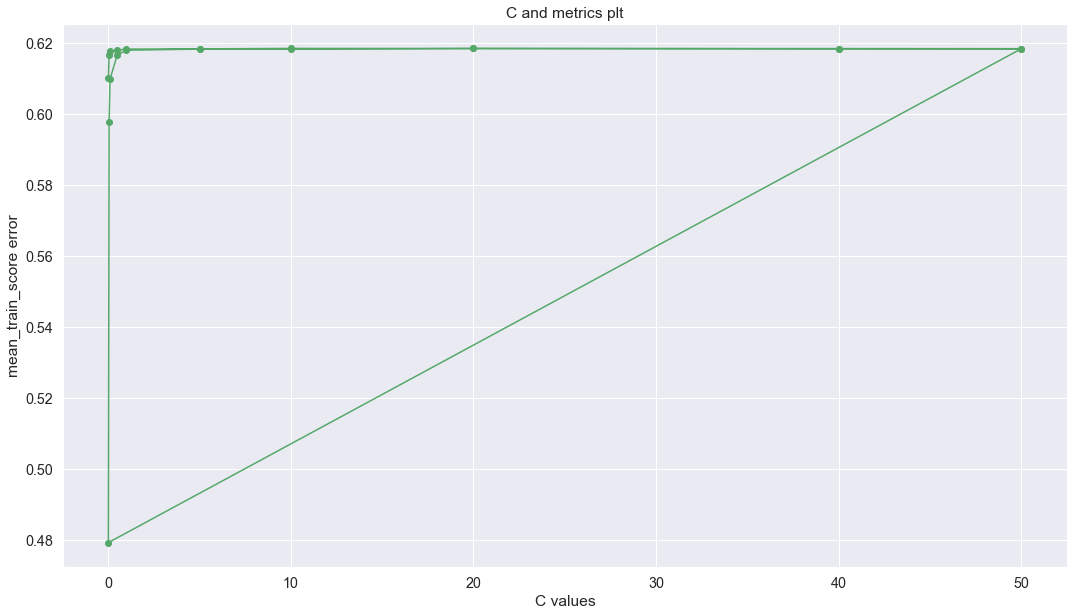

In [78]:
create_cv_plot(bclf)

In [79]:
bclf.best_params_

{'classify__C': 0.5, 'classify__penalty': 'l1'}

In [80]:
baseline_logit.set_params(** bclf.best_params_)

Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('impute', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbos...alty='l1', random_state=33,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [81]:
log_with_best_params = baseline_logit.fit(X_train, y_train)

D:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


on train
              precision    recall  f1-score   support

         0.0       0.87      0.56      0.68      3566
         1.0       0.19      0.57      0.28       656

   micro avg       0.56      0.56      0.56      4222
   macro avg       0.53      0.56      0.48      4222
weighted avg       0.77      0.56      0.62      4222

AUC
0.587849079381147


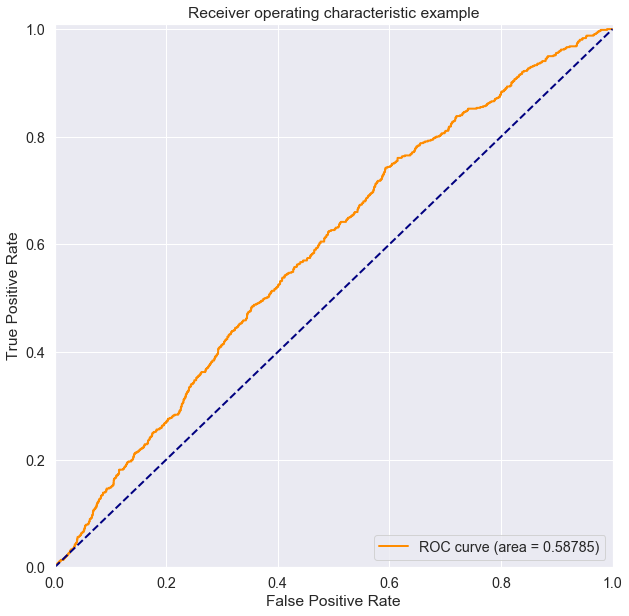

array([0.57466383, 0.58669228, 0.44884818, ..., 0.53527745, 0.50237596,
       0.43990726])

In [82]:
classify(log_with_best_params)

In [935]:
df_backup = df.copy()

In [1194]:
df = df_backup.copy()

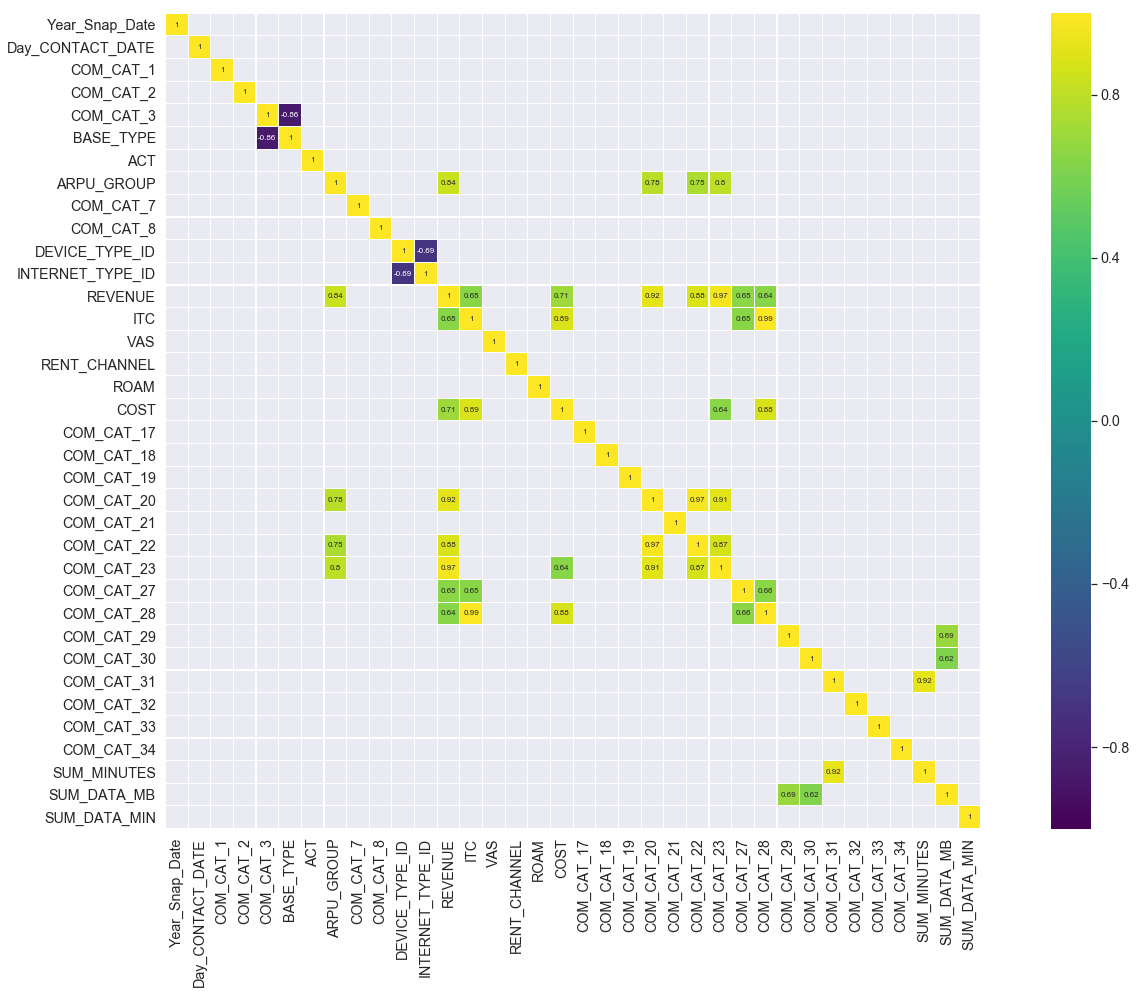

In [1179]:
df_feature_corr = df.drop(['SK_ID',target], axis = 1).corr(method = 'pearson')

plt.figure(figsize=(25, 15))
sns.heatmap(df_feature_corr[abs(df_feature_corr) > 0.6], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [1133]:
#df.drop('COM_CAT_28',axis = 1, inplace = True)

In [1134]:
#df.drop('COM_CAT_23',axis = 1, inplace = True)

In [1135]:
#df.drop('COM_CAT_22',axis = 1, inplace = True)

In [1136]:
#df.drop('COM_CAT_27',axis = 1, inplace = True) признак нужный
#df.drop('COM_CAT_21',axis = 1, inplace = True) # may be profit!
#df.drop('COM_CAT_20',axis = 1, inplace = True)
#df.drop('REVENUE',axis = 1, inplace = True) # need feature

In [1107]:
df.drop('Month_CONTACT_DATE',axis = 1, inplace = True)# дроп этой фичи улучшает скор

In [1108]:
df.drop('COM_CAT_26',axis = 1, inplace = True)# дроп этой фичи улучшает скор

In [1195]:
df.drop('Month_Snap_Date',axis = 1, inplace = True) #немного возрос auc

In [1196]:
df.drop('Year_Snap_Date',axis = 1, inplace = True) # немного улучшает скор

In [1181]:
#df.drop('Day_CONTACT_DATE',axis = 1, inplace = True)

In [1039]:
df.head()

,SK_ID,CSI,Year_Snap_Date,Month_Snap_Date,Day_CONTACT_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34,SUM_MINUTES,SUM_DATA_MB,SUM_DATA_MIN
0,2,0.0,1,5,4,7,77.0,11.800000,1,1.0,8.600000,2,1318.000000,5.0,2.0,0.128128,0.004327,0.084167,0.055287,0.0,0.004673,0.000000,0.0,0.038407,0.032714,0.704449,0.128508,0.003220,0.004140,0.000038,0.002244,0.029528,0.027579,0.103896,9.0,0.144137,0.012112,1.093219
1,3,0.0,2,9,21,4,51.0,13.000000,1,1.0,8.222222,2,751.444444,5.0,2.0,0.133601,0.015793,0.106932,0.055055,0.0,0.007315,0.068165,0.0,0.026212,0.023984,0.702567,0.132894,0.008828,0.015793,0.000972,0.000070,0.011613,0.027579,0.103896,9.0,0.112944,0.009155,1.395130
2,4,0.0,2,12,27,8,12.0,3.833333,2,1.0,6.166667,3,1102.333333,3.0,3.0,0.118478,0.004834,0.085881,0.055038,0.0,0.004817,0.000000,0.0,0.026212,0.019298,0.701650,0.116275,0.014066,0.003972,0.000000,0.000000,0.039371,0.027579,0.103896,3.0,0.246722,0.000000,0.000000
3,5,0.0,2,12,8,3,79.0,2.000000,2,1.0,8.833333,1,110.000000,5.0,2.0,0.129951,0.002000,0.085055,0.063784,0.0,0.005164,0.000000,0.0,0.026212,0.019298,0.705427,0.130530,0.003737,0.002000,0.071332,0.001833,0.051395,0.027579,0.103896,2.0,0.402554,0.416140,2.278583
4,6,1.0,2,12,6,5,48.0,5.000000,2,1.0,2.166667,4,937.000000,3.0,3.0,0.108780,0.000103,0.084285,0.054984,0.0,0.004226,0.000000,0.0,0.026212,0.019298,0.698688,0.109785,0.001804,0.000103,0.000000,0.000000,0.012235,0.027579,0.103900,3.0,0.073116,0.000000,0.000000


In [1197]:
split_index = 9443-5221

In [1198]:
y = df[target]

In [1199]:
X_train,X_test = df[:split_index].drop([target,'SK_ID'], axis = 1),df[split_index:].drop([target,'SK_ID'], axis = 1)

In [1200]:
y_train = y[:split_index]

Pipeline.

In [1201]:
df_num_features = list(df).copy()
df_num_features.remove(target)
df_num_features.remove('SK_ID')
#df_num_features

In [1202]:
num_features_pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean',copy = False)),
    ('scale', MinMaxScaler()),
    ('transform', QuantileTransformer(output_distribution='normal'))
])

In [1203]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_features_pipeline, df_num_features),
        #('cat_ext', cat_ext_features_pipeline, cat_ext),
        #('cat_bin', cat_bin_features_pipeline, cat_bin)
    ]
)

#### SVC.

In [1204]:
from sklearn.feature_selection import SelectFromModel

In [1205]:
svc = SVC(kernel = 'rbf',
          gamma = 'scale',
          #C = 5, #with c = 5 strong overfit
          random_state = seed,          
          decision_function_shape = 'ovr',                             
          class_weight = 'balanced',     
          probability = True)

baseline_SVC = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classify', svc)
    ]
)

In [1206]:
cvs_classify = baseline_SVC.fit(X_train, y_train)

In [1207]:
cross_val_score(cvs_classify, X_train, y_train, cv=10, scoring='roc_auc',n_jobs = -1).mean()

0.5511724549959844

on train
              precision    recall  f1-score   support

         0.0       0.94      0.69      0.80      3566
         1.0       0.32      0.77      0.45       656

   micro avg       0.70      0.70      0.70      4222
   macro avg       0.63      0.73      0.62      4222
weighted avg       0.85      0.70      0.74      4222

AUC
0.8178704191346456


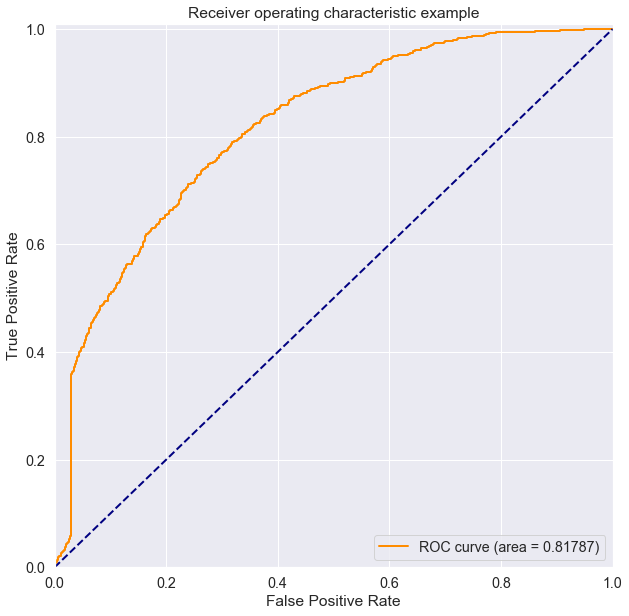

In [1208]:
results = classify(cvs_classify)

In [1209]:
results.shape
results = pd.DataFrame(results)

In [1210]:
results.to_csv("out_svc_dropped_features_v3.csv", sep='\t', encoding='utf-8',index = False, header = False)

In [89]:
#print test

In [90]:
%%time

my_scorer = make_scorer(f1_score, average='weighted')
skv = KFold(n_splits = 10,random_state=seed, shuffle=False)

'''    {
    'classify__kernel': ['poly'],
    'classify__degree': [1, 2, 3],
    'classify__coef0': [0, 0.5, 1],
    'classify__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20]
                    },'''

tuned_parameters = [
    {
    'classify__kernel': ['poly'],
    'classify__degree': [1, 2, 3],
    'classify__coef0': [0, 0.5, 1],
    'classify__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20]
                    },

    {
    'classify__kernel': ['rbf'],
    'classify__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 40],
    'classify__gamma': [0.001,0.01, 0.05, 0.1, 0.5, 1]
                    },
    {
    'classify__kernel': [ 'sigmoid'],
    'classify__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 40],
    'classify__coef0': [0.1, 0.5, 1, 5]
                    }
]


bsvc = GridSearchCV(baseline_SVC, tuned_parameters,
                   scoring=my_scorer, cv=skv, verbose=8, n_jobs=-1,refit='roc_auc')

#bsvc.fit(X_train, y_train)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 2

Wall time: 33min 45s


In [120]:
means = bsvc.cv_results_['mean_test_score']
stds = bsvc.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, bsvc.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

0.511 (+/-0.066) for {'classify__C': 0.01, 'classify__coef0': 0, 'classify__degree': 1, 'classify__kernel': 'poly'}
0.546 (+/-0.058) for {'classify__C': 0.01, 'classify__coef0': 0, 'classify__degree': 2, 'classify__kernel': 'poly'}
0.619 (+/-0.053) for {'classify__C': 0.01, 'classify__coef0': 0, 'classify__degree': 3, 'classify__kernel': 'poly'}
0.511 (+/-0.066) for {'classify__C': 0.01, 'classify__coef0': 0.5, 'classify__degree': 1, 'classify__kernel': 'poly'}
0.539 (+/-0.058) for {'classify__C': 0.01, 'classify__coef0': 0.5, 'classify__degree': 2, 'classify__kernel': 'poly'}
0.628 (+/-0.061) for {'classify__C': 0.01, 'classify__coef0': 0.5, 'classify__degree': 3, 'classify__kernel': 'poly'}
0.511 (+/-0.066) for {'classify__C': 0.01, 'classify__coef0': 1, 'classify__degree': 1, 'classify__kernel': 'poly'}
0.534 (+/-0.058) for {'classify__C': 0.01, 'classify__coef0': 1, 'classify__degree': 2, 'classify__kernel': 'poly'}
0.627 (+/-0.064) for {'classify__C': 0.01, 'classify__coef0': 1, '

In [110]:
bsvc.best_params_

{'classify__C': 0.5, 'classify__gamma': 1, 'classify__kernel': 'rbf'}

In [134]:
baseline_SVC.set_params(** bsvc.best_params_)

Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('impute', SimpleImputer(copy=False, fill_value=None, missing_values=nan,
       strategy='mean', verbos...bf',
  max_iter=-1, probability=True, random_state=33, shrinking=True,
  tol=0.001, verbose=False))])

In [135]:
#baseline_SVC.named_steps

on train
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3566
         1.0       1.00      1.00      1.00       656

   micro avg       1.00      1.00      1.00      4222
   macro avg       1.00      1.00      1.00      4222
weighted avg       1.00      1.00      1.00      4222

AUC
0.0


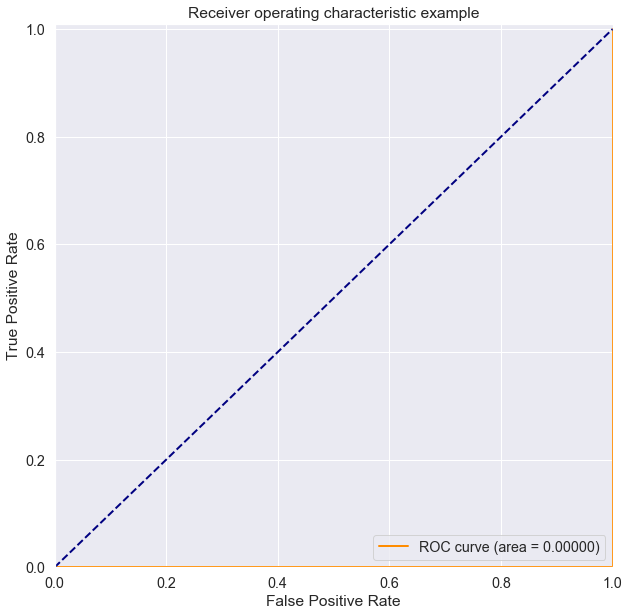

In [136]:
results = classify(baseline_SVC)

In [98]:
results.shape
results = pd.DataFrame(results)

In [112]:
results.to_csv("out_svc_best_params.csv", sep='\t', encoding='utf-8',index = False, header = False)

#### Feature Importance. Oversample. XGBOOST.

In [994]:
clf_log = LogisticRegression(multi_class = 'ovr',
                             solver='saga',
                             random_state = seed,
                             n_jobs = -1,
                             max_iter = 10e2,
                             class_weight='balanced',
                             penalty = 'l1',
                             C = 40
                            )

In [995]:
baseline_logit = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classify', clf_log)
    ]
)

In [996]:
most_ft = baseline_logit.fit(X_train,y_train)

on train
              precision    recall  f1-score   support

         0.0       0.88      0.55      0.68      3566
         1.0       0.19      0.59      0.29       656

   micro avg       0.56      0.56      0.56      4222
   macro avg       0.54      0.57      0.48      4222
weighted avg       0.77      0.56      0.62      4222

AUC
0.593646122594148


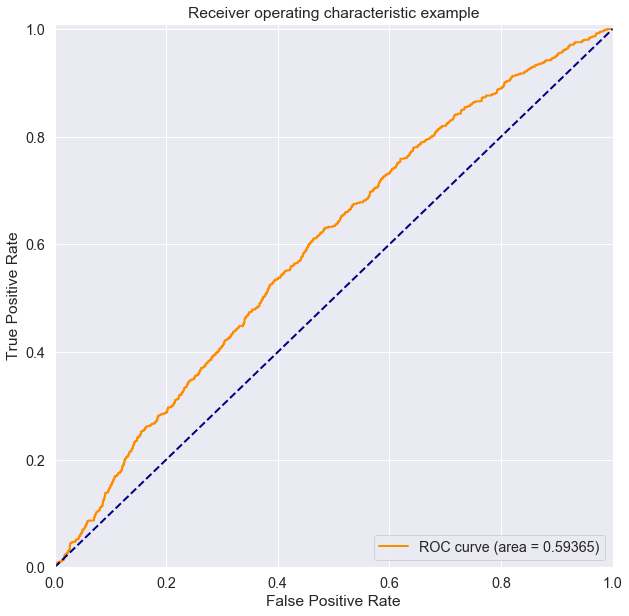

In [997]:
results = classify(most_ft)

In [998]:
results.shape
results = pd.DataFrame(results)

In [999]:
results.to_csv("out.csv", sep='\t', encoding='utf-8',index = False, header = False)

In [1000]:
coefs = most_ft.steps[1][1].coef_

In [1001]:
coefs = pd.DataFrame(np.abs(coefs), columns = (df_num_features))

In [1002]:
coefs[coefs > 0.1].T

,0
Year_Snap_Date,NaN
Day_CONTACT_DATE,NaN
COM_CAT_1,NaN
COM_CAT_2,NaN
COM_CAT_3,NaN
BASE_TYPE,NaN
ACT,NaN
ARPU_GROUP,NaN
COM_CAT_7,NaN
COM_CAT_8,NaN


#### XGBoost.

In [520]:
# fit model no training data
params={
    'n_estimators':400,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':4,
    'max_depth':5,
    'seed':seed,
    'eval_metric':'auc',
    
    }

xbg_clf = XGBClassifier(**params)


In [521]:
baseline_logit = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('classify', xbg_clf)
    ]
)

In [522]:
xgb = baseline_logit.fit(X_train,y_train)

on train
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      3566
         1.0       1.00      0.31      0.48       656

   micro avg       0.89      0.89      0.89      4222
   macro avg       0.94      0.66      0.71      4222
weighted avg       0.91      0.89      0.87      4222

AUC
0.990805353405469


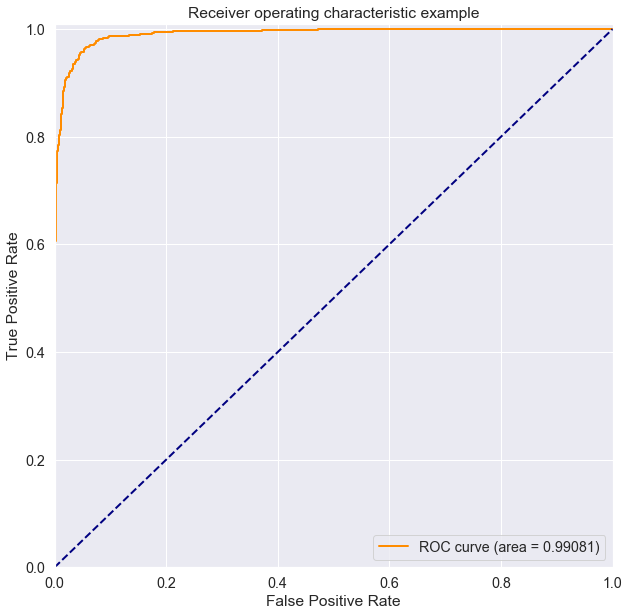

In [523]:
results = classify(xgb)

In [524]:
results.shape
results = pd.DataFrame(results)

In [525]:
results.to_csv("xgb_v1.csv", sep='\t', encoding='utf-8',index = False, header = False)